transform VED 4 from keras to pytorch 

In [1]:
import tensorflow as tf
from cbrain import *
import torch as to
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps

2022-11-02 09:56:48.337417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# reparameterization trick of VAE 
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    based on VAE presented on keras webpage for keras version 1 /
    recent keras VAE version can be seen on
    https://keras.io/examples/generative/vae/
    """

    z_mean, z_log_var = args
    batch= K.shape(z_mean)[0]
    dim=K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon=K.random_normal(shape=(batch,dim)) # epsilion= random_normal distributed tensor
    sample_prob=z_mean+K.exp(0.5*z_log_var)*epsilon #exp= elementwise exponential
    return sample_prob


In [3]:
def sampling_to(mean,log_var):
    """
    reparameterization trick in pytorch
    author: G. Behrens 
    """
    z_mean=mean
    z_log_var =log_var
    batch= z_mean.size(dim=0) #K.shape(z_mean)[0]
    dim=z_mean.size(dim=1)
    eps=to.normal(mean=0.0,std=1.0,size=(batch,dim))
    sampling_prob=z_mean+to.exp(0.5*z_log_var)*eps
    return sampling_prob

In [4]:
# define some hyperparameter 
original_dim_input=109  # CBRAIN input node size

original_dim_output=int(113) # CBRAIN output node size 


# network parameters
latent_dim=12
intermediate_dim = 359     
batch_size = 2313     
kl_weight=5.014574306764403e-05
lr_init=0.0014573654353561966
act='leaky_relu'


input_shape = (original_dim_input,)
decoder_input_shape=(latent_dim,)
out_shape=(original_dim_output,)

In [9]:
# build VED 4 in keras 

input_lay=Input(shape=input_shape, name='encoder_input')
x_0 =Dense(intermediate_dim, activation=act)(input_lay)
x_1 =Dense(intermediate_dim/2, activation=act)(x_0)
x_2 =Dense(intermediate_dim/4, activation=act)(x_1)
x_3 =Dense(intermediate_dim/8, activation=act)(x_2)
x_4 =Dense(intermediate_dim/16, activation=act)(x_3)
z_mean = Dense(latent_dim, name='z_mean')(x_4)
z_log_var = Dense(latent_dim, name='z_log_var')(x_4)



# reparametrization trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(input_lay, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
    
input_decoder=Input(shape=decoder_input_shape, name='decoder_input')
x_0 =Dense(intermediate_dim/16, activation=act)(input_decoder)
x_1 =Dense(intermediate_dim/8, activation=act)(x_0)
x_2 =Dense(intermediate_dim/4, activation=act)(x_1)
x_3 =Dense(intermediate_dim/2, activation=act)(x_2)
x_4 =Dense(intermediate_dim, activation=act)(x_3)


outputs_1= Dense(original_dim_output,activation=act)(x_4)
outputs_A = Dense(104,activation='linear')(outputs_1)
outputs_B = Dense(9,activation='relu')(outputs_1)
outputs= Concatenate()([outputs_A,outputs_B])
 
    
# instantiate encoder model
decoder = Model(input_decoder, outputs, name='decoder')
decoder.summary()
decoder_outputs=decoder(encoder(input_lay)[2])
VED_4=Model(input_lay,decoder_outputs, name='VED')
VED_4.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 109)]        0           []                               
                                                                                                  
 dense_13 (Dense)               (None, 359)          39490       ['encoder_input[0][0]']          
                                                                                                  
 dense_14 (Dense)               (None, 179)          64440       ['dense_13[0][0]']               
                                                                                                  
 dense_15 (Dense)               (None, 89)           16020       ['dense_14[0][0]']               
                                                                                            

In [10]:
# load weights into keras VED 4 

VED_4.load_weights('real_geography/VEDs/VED_4/VED_4_weights.h5',by_name=True)
VED_4.summary()
VED_4_weights=VED_4.get_weights()



Model: "VED"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 109)]             0         
                                                                 
 encoder (Functional)        [(None, 12),              125452    
                              (None, 12),                        
                              (None, 12)]                        
                                                                 
 decoder (Functional)        (None, 113)               139595    
                                                                 
Total params: 265,047
Trainable params: 265,047
Non-trainable params: 0
_________________________________________________________________


load pytorch

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
# build Encoder in pytorch 
    
    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.X_1=nn.Linear(109,VED_4_weights[0].shape[1])
        self.X_2=nn.Linear(VED_4_weights[0].shape[1],VED_4_weights[2].shape[1])
        self.X_3=nn.Linear(VED_4_weights[2].shape[1],VED_4_weights[4].shape[1])
        self.X_4=nn.Linear(VED_4_weights[4].shape[1],VED_4_weights[6].shape[1])
        self.X_5=nn.Linear(VED_4_weights[6].shape[1],VED_4_weights[8].shape[1])
        self.z_mean=nn.Linear(VED_4_weights[8].shape[1],VED_4_weights[10].shape[1])
        self.z_log_var=nn.Linear(VED_4_weights[8].shape[1],VED_4_weights[12].shape[1])
        
        

           
    def forward(self,x):
        
        x=F.leaky_relu(self.X_1(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_2(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_3(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_4(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_5(x),negative_slope=0.2)
        x_1=self.z_mean(x)
        x_2=self.z_log_var(x)
        x=sampling_to(x_1,x_2)
            
        return x

        
        
# build Decoder in pytorch        
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.X_1=nn.Linear(VED_4_weights[12].shape[1],VED_4_weights[14].shape[1])
        self.X_2=nn.Linear(VED_4_weights[14].shape[1],VED_4_weights[16].shape[1])
        self.X_3=nn.Linear(VED_4_weights[16].shape[1],VED_4_weights[18].shape[1])
        self.X_4=nn.Linear(VED_4_weights[18].shape[1],VED_4_weights[20].shape[1])
        self.X_5=nn.Linear(VED_4_weights[20].shape[1],VED_4_weights[22].shape[1])
        self.X_6=nn.Linear(VED_4_weights[22].shape[1],VED_4_weights[24].shape[1])
        self.X_7=nn.Linear(VED_4_weights[24].shape[1],VED_4_weights[26].shape[1])
        self.X_8=nn.Linear(VED_4_weights[26].shape[1],VED_4_weights[28].shape[1])


    def forward(self,x):
        x=F.leaky_relu(self.X_1(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_2(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_3(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_4(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_5(x),negative_slope=0.2)
        x=F.leaky_relu(self.X_6(x),negative_slope=0.2)

        x_1=self.X_7(x)
        x_2=F.relu(self.X_8(x))
        x=to.cat([x_1,x_2],1)

            
        return x

        
        
      
    
        



        


In [14]:
# construct Encoder, Decoder 
Encoder_4=Encoder()
Decoder_4=Decoder()

print(Encoder_4)
print(Decoder_4)



Encoder(
  (X_1): Linear(in_features=109, out_features=359, bias=True)
  (X_2): Linear(in_features=359, out_features=179, bias=True)
  (X_3): Linear(in_features=179, out_features=89, bias=True)
  (X_4): Linear(in_features=89, out_features=44, bias=True)
  (X_5): Linear(in_features=44, out_features=22, bias=True)
  (z_mean): Linear(in_features=22, out_features=12, bias=True)
  (z_log_var): Linear(in_features=22, out_features=12, bias=True)
)
Decoder(
  (X_1): Linear(in_features=12, out_features=22, bias=True)
  (X_2): Linear(in_features=22, out_features=44, bias=True)
  (X_3): Linear(in_features=44, out_features=89, bias=True)
  (X_4): Linear(in_features=89, out_features=179, bias=True)
  (X_5): Linear(in_features=179, out_features=359, bias=True)
  (X_6): Linear(in_features=359, out_features=113, bias=True)
  (X_7): Linear(in_features=113, out_features=104, bias=True)
  (X_8): Linear(in_features=104, out_features=9, bias=True)
)


In [15]:
# load keras weights in pytorch Encoder 

Encoder_4.X_1.weight.data=to.from_numpy(np.transpose(VED_4_weights[0]))
Encoder_4.X_1.bias.data=to.from_numpy(np.transpose(VED_4_weights[1]))
Encoder_4.X_2.weight.data=to.from_numpy(np.transpose(VED_4_weights[2]))
Encoder_4.X_2.bias.data=to.from_numpy(np.transpose(VED_4_weights[3]))
Encoder_4.X_3.weight.data=to.from_numpy(np.transpose(VED_4_weights[4]))
Encoder_4.X_3.bias.data=to.from_numpy(np.transpose(VED_4_weights[5]))
Encoder_4.X_4.weight.data=to.from_numpy(np.transpose(VED_4_weights[6]))
Encoder_4.X_4.bias.data=to.from_numpy(np.transpose(VED_4_weights[7]))
Encoder_4.X_5.weight.data=to.from_numpy(np.transpose(VED_4_weights[8]))
Encoder_4.X_5.bias.data=to.from_numpy(np.transpose(VED_4_weights[9]))
Encoder_4.z_mean.weight.data=to.from_numpy(np.transpose(VED_4_weights[10]))
Encoder_4.z_mean.bias.data=to.from_numpy(np.transpose(VED_4_weights[11]))
Encoder_4.z_log_var.weight.data=to.from_numpy(np.transpose(VED_4_weights[12]))
Encoder_4.z_log_var.bias.data=to.from_numpy(np.transpose(VED_4_weights[13]))



In [16]:
# load keras weights in pytorch Decoder 


Decoder_4.X_1.weight.data=to.from_numpy(np.transpose(VED_4_weights[14]))
Decoder_4.X_1.bias.data=to.from_numpy(np.transpose(VED_4_weights[15]))
Decoder_4.X_2.weight.data=to.from_numpy(np.transpose(VED_4_weights[16]))
Decoder_4.X_2.bias.data=to.from_numpy(np.transpose(VED_4_weights[17]))
Decoder_4.X_3.weight.data=to.from_numpy(np.transpose(VED_4_weights[18]))
Decoder_4.X_3.bias.data=to.from_numpy(np.transpose(VED_4_weights[19]))
Decoder_4.X_4.weight.data=to.from_numpy(np.transpose(VED_4_weights[20]))
Decoder_4.X_4.bias.data=to.from_numpy(np.transpose(VED_4_weights[21]))
Decoder_4.X_5.weight.data=to.from_numpy(np.transpose(VED_4_weights[22]))
Decoder_4.X_5.bias.data=to.from_numpy(np.transpose(VED_4_weights[23]))
Decoder_4.X_6.weight.data=to.from_numpy(np.transpose(VED_4_weights[24]))
Decoder_4.X_6.bias.data=to.from_numpy(np.transpose(VED_4_weights[25]))
Decoder_4.X_7.weight.data=to.from_numpy(np.transpose(VED_4_weights[26]))
Decoder_4.X_7.bias.data=to.from_numpy(np.transpose(VED_4_weights[27]))
Decoder_4.X_8.weight.data=to.from_numpy(np.transpose(VED_4_weights[28]))
Decoder_4.X_8.bias.data=to.from_numpy(np.transpose(VED_4_weights[29]))


In [17]:
# define input and output vars 
in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND', 'PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 2 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values

NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values




# defining the scaling dict for the VED training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}




# load vertical levels in pressure coords 

from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


# load test data set 

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [18]:
# predict with keras
pred_keras= VED_4.predict(val_gen_II[300][0])

432/432 [==============================] - 1s 823us/step


In [19]:
print(pred_keras.shape)
pred_keras[0]

(13824, 113)


array([-1.69602958e-31,  1.79476358e-32, -2.47586570e-31,  9.78278372e-32,
       -5.13813211e-06, -1.69860141e-06, -1.14791169e-06,  2.48339347e-07,
        1.85753834e-06,  5.90611489e-06,  2.09037971e-05,  4.13128291e-05,
        9.27762594e-05,  1.32456888e-04,  3.24252993e-04,  1.25203561e-03,
        2.19938159e-03,  1.87718356e-03,  1.17187947e-03, -3.23747285e-03,
       -5.32814395e-03, -3.86206433e-04,  1.14656985e-04, -3.83381173e-03,
       -6.82310760e-03, -1.29291415e-03,  5.15100658e-02,  3.89103591e-03,
       -4.28652763e-03,  5.43620437e-04,  4.21100855e-03,  5.17024659e-03,
        5.94714098e-03,  1.27548771e-03,  6.53020851e-03,  2.77095428e-03,
        1.54473446e-03, -1.17580313e-03, -3.35437618e-03, -2.68550869e-03,
        1.14776753e-03, -1.38676167e-03, -5.34047652e-03, -8.76493379e-03,
       -1.04178041e-02, -6.96563721e-03, -5.28328121e-03, -1.77334547e-02,
       -2.51487792e-02, -7.27280229e-03, -1.08043104e-03,  6.86612912e-03,
        1.36825662e-31,  

In [20]:
# predict with pytorch
pred_pytorch=Decoder_4(Encoder_4(to.from_numpy(val_gen_II[300][0])))
pred_pytorch[0]

tensor([ 6.2223e-31,  7.8893e-31,  4.1847e-31,  7.7786e-31, -2.8837e-06,
         3.0518e-06, -7.7076e-07, -4.5413e-08,  1.6463e-06,  6.9068e-06,
         3.0340e-05,  1.0367e-04,  3.4583e-04,  7.0984e-04,  1.3095e-03,
         2.8728e-03,  4.7781e-03,  4.9788e-03,  3.2378e-03, -2.0298e-03,
        -3.4662e-03, -1.2267e-03, -2.1948e-03, -1.0911e-02,  1.9428e-03,
        -2.4583e-02,  5.2343e-02,  3.5797e-03, -5.2527e-03,  4.9899e-04,
         4.6002e-03,  5.0655e-03,  5.3908e-03,  1.5307e-03,  6.6146e-03,
         3.5612e-03,  2.7743e-03,  6.5519e-04,  2.1744e-03,  3.2697e-03,
         4.0321e-03,  1.1046e-03, -8.2630e-03, -1.6991e-02, -2.0637e-02,
        -1.8835e-02, -2.3394e-02, -2.3702e-02, -2.0277e-02, -2.7460e-02,
        -3.3458e-02,  2.2137e-02,  7.5745e-31, -4.3006e-31,  2.5305e-32,
         6.8899e-31, -4.1248e-31,  4.7643e-29,  9.3961e-28,  2.0101e-25,
        -4.8656e-23, -4.7515e-21, -8.7390e-19,  9.9925e-17,  2.0178e-14,
         4.2568e-12,  1.8291e-05,  2.5555e-03,  9.7

In [21]:
pred_pytorch.shape

torch.Size([13824, 113])

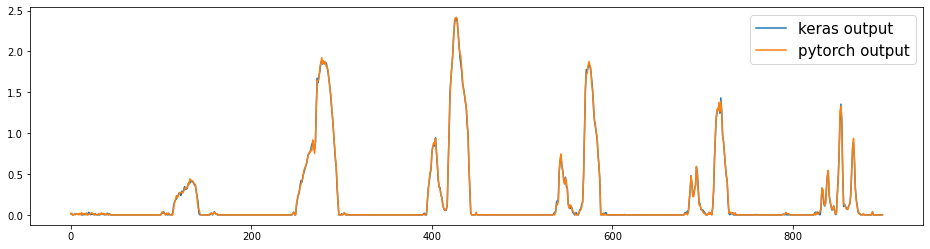

In [22]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,106],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,106],label='pytorch output')
plt.legend(fontsize=15)

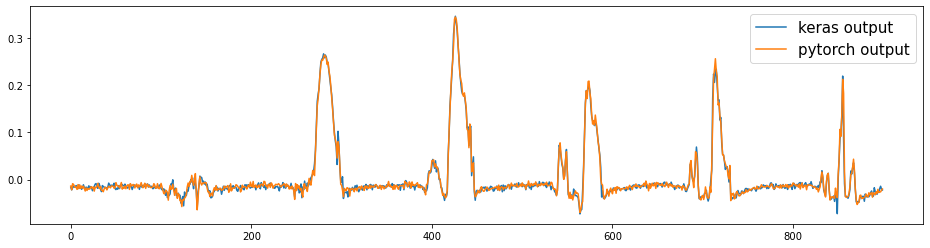

In [23]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,45],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,45],label='pytorch output')
plt.legend(fontsize=15)

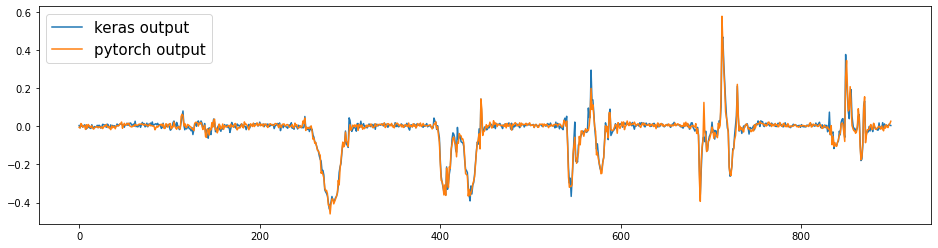

In [24]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,73],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,73],label='pytorch output')
plt.legend(fontsize=15)

In [25]:
a=np.isclose(pred_keras,pred_pytorch.detach().numpy(),atol=1E-3)

In [26]:
a.shape

(13824, 113)

In [27]:
np.where(a==False)[0].size

841743

In [28]:
np.where(a==True)[0].size

720369

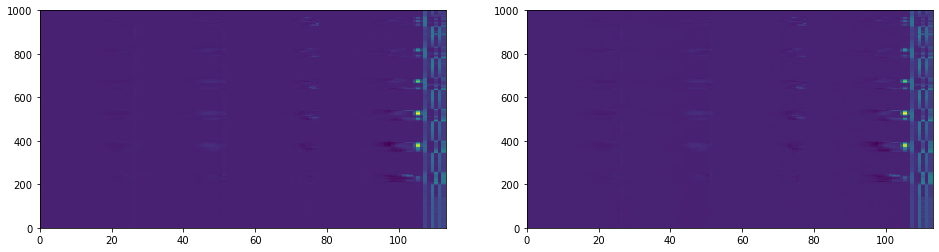

In [29]:
plt.figure(1,(16,4))
plt.subplot(1,2,1)
plt.pcolor(pred_keras[0:1000])
plt.subplot(1,2,2)
plt.pcolor(pred_pytorch.detach().numpy()[0:1000])


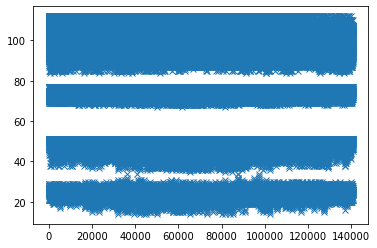

In [30]:
plt.plot(np.where(pred_keras-pred_pytorch.detach().numpy()>=1E-2)[1],'x')#np.max(pred_keras-pred_pytorch.detach().numpy()))

In [31]:
# save weights and biases of pytorch VED 4

to.save(Encoder_4,'real_geography/VEDs/VED_4/VEncoder_4_torch.pt')
to.save(Decoder_4,'real_geography/VEDs/VED_4/VDecoder_4_torch.pt')


In [32]:
# save Encoder 4 in pytorch 
enc_mod = to.jit.trace(Encoder_4, to.from_numpy(val_gen_II[300][0]))
to.jit.save(enc_mod,'real_geography/VEDs/VED_4/VEncoder_4_torch_jit.pt')

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/jit/_trace.py:992: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 165849 / 165888 (100.0%)
Greatest absolute difference: 5.0115296840667725 at index (13231, 9) (up to 1e-05 allowed)
Greatest relative difference: 30380.113725490195 at index (660, 5) (up to 1e-05 allowed)
  _check_trace(


In [33]:
# save Decoder 4 in pytorch 

dec_mod = to.jit.trace(Decoder_4, Encoder_4(to.from_numpy(val_gen_II[300][0])))
to.jit.save(dec_mod,'real_geography/VEDs/VED_4/VDecoder_4_torch_jit.pt')

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664817698971/work/build/aten/src/ATen/core/TensorBody.h:477.)
  return self._grad
